## Step 0: Clean Data

In [82]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve,roc_auc_score
from PIL import Image
from torch.utils.data import TensorDataset

excel_file = 'Data_Balanced/metadata_balanced.csv'
root_folder = r'Data_Balanced'
image_folder = os.path.join(root_folder, 'images')
train_folder = os.path.join(root_folder, 'train')
test_folder = os.path.join(root_folder, 'test')

In [83]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [84]:
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

C:\Users\chana\anaconda3\lib\site-packages\torch\cuda\memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
C:\Users\chana\anaconda3\lib\site-packages\torch\cuda\memory.py:329: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [85]:
# Read the metadata file.
df = pd.read_csv(excel_file)

In [86]:
# Remove Nulls and remove indeterminate class.
df = df[~df['benign_malignant'].isna()]
df = df[df['benign_malignant'].isin(['benign','malignant'])]
df.head(5)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,image_type,melanocytic,sex
0,ISIC_0000002,Anonymous,CC-0,60.0,upper extremity,malignant,melanoma,histopathology,dermoscopic,True,female
1,ISIC_0000004,Anonymous,CC-0,80.0,posterior torso,malignant,melanoma,histopathology,dermoscopic,True,male
2,ISIC_0000026,Anonymous,CC-0,30.0,lower extremity,malignant,melanoma,histopathology,dermoscopic,True,female
3,ISIC_0000029,Anonymous,CC-0,45.0,posterior torso,malignant,melanoma,histopathology,dermoscopic,True,female
4,ISIC_0000030,Anonymous,CC-0,55.0,lower extremity,malignant,melanoma,histopathology,dermoscopic,True,female


In [87]:
print('Unique Images',df['isic_id'].nunique())

Unique Images 2589


In [88]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

In [89]:
# Move images to 'train' folder
for index, row in train_df.iterrows():
    image_filename = row['isic_id'] + '.jpg'
    label = row['benign_malignant']
    src_path = os.path.join(image_folder, image_filename)
    dst_path = os.path.join(train_folder, label, image_filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)


In [90]:
# Move images to 'test' folder
for index, row in test_df.iterrows():
    image_filename = row['isic_id'] + '.jpg'
    label = row['benign_malignant']
    src_path = os.path.join(image_folder, image_filename)
    dst_path = os.path.join(test_folder, label, image_filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

In [91]:
# Check class distribution
df['benign_malignant'].value_counts()

benign       1300
malignant    1289
Name: benign_malignant, dtype: int64

In [92]:
train_df.to_csv('train.csv',index = False)
test_df.to_csv('test.csv',index = False)

In [93]:


# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((512,512)),  # Resize the images to a fixed size
    transforms.RandomHorizontalFlip(), # Randomly flip images 
    transforms.RandomRotation(15), # Randomly rotate images
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image data
])

# Create datasets for 'train' and 'test' sets
train_dataset = datasets.ImageFolder(train_folder,transform = transform) 
test_dataset = datasets.ImageFolder(test_folder,transform = transform)




In [94]:
print(dict(Counter(train_dataset.targets)))
print(dict(Counter(test_dataset.targets)))

{0: 652, 1: 642}
{0: 648, 1: 647}


In [95]:
indices = torch.randperm(len(test_dataset))
indices

tensor([  15,  586, 1080,  ...,  284,  454,  608])

In [96]:
def set_training_structure(structure = 'multi_epoch',epoch = 20):
    if structure == 'multi_epoch':
        train_loader = DataLoader(train_dataset, batch_size=50, shuffle = True)
        indices = torch.randperm(len(test_dataset))
        test_loader = DataLoader(test_dataset, batch_size=50,shuffle = False,sampler=torch.utils.data.SubsetRandomSampler(indices))
        return train_loader,test_loader,epoch
        
    elif structure == 'single_epoch':
        train_loader = DataLoader(train_dataset, batch_size=50, shuffle = True)
        indices = torch.randperm(len(test_dataset))
        test_loader = DataLoader(test_dataset, batch_size=50,shuffle = False,sampler=torch.utils.data.SubsetRandomSampler(indices))
        epoch = 1
        return train_loader,test_loader,epoch
    
    else:
        return None      

In [97]:
train_loader,test_loader,epoch = set_training_structure(structure = 'multi_epoch')

In [98]:
for img in train_loader:
    x = img[0]
    print(x.shape)
    break

torch.Size([50, 3, 512, 512])


## Step 1: Find p(W)

In [99]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(14400, 60)
        self.fc2 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = Net().to(device)

In [100]:
## Correct weights should be: (120,14400)
weights = net.fc1.weight.data
weights = weights.cpu().data.numpy()
weights.shape

(60, 14400)

In [101]:
def train_model(net,data_loader,epoch,eps,count_to_stop):
    train_losses_all = []
    val_losses_all = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    stop_training = False
    count = 0
    for e in range(epoch):  # loop over the dataset multiple times
        net.train()
        if stop_training == False:
            print('Epoch:',e)
            running_loss = 0.0
            running_out = 0
            running_lab = 0
    
            for i, data in enumerate(data_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                r_out = sum(torch.argmax(outputs,axis = 1))
                r_lab = sum(labels)
            
    
                # print statistics
                running_loss += loss.item()
            
                print('loss',loss.item())
    
                if i % 50 == 49:    # print every 50 mini-batches
                    print('output mean',r_out/50)
                    print('lab mean',r_lab/50)
            
    weights = net.fc1.weight.data.cpu().data.numpy()
    biases = net.fc1.bias.data.cpu().data.numpy()
    
    weights_2 = net.fc2.weight.data.cpu().data.numpy()
    biases_2 = net.fc2.bias.data.cpu().data.numpy()

    
    print('Finished Training')    
    return net,weights,biases,weights_2,biases_2


        

In [102]:
no_models = 1
weights_list = []
biases_list = []
weights_list2 = []
biases_list2 = []
for i in range(no_models):
    net = Net().to(device)
    #Set biases to 0 and freeze  km                                                                                                                                                                                                                                                                                                                     
    net.fc1.bias.data = torch.zeros(60).cuda()
    net.fc1.bias.requires_grad = False
    #Train model and save weights
    net,weights,biases,weights_2,biases_2 = train_model(net,train_loader,epoch = epoch,eps = 0.2,count_to_stop = 3)
    weights_list.append(weights)
    biases_list.append(biases)
    weights_list2.append(weights_2)
    biases_list2.append(biases_2)

Epoch: 0
loss 0.6885282397270203
loss 0.6921812295913696
loss 0.6844272613525391
loss 0.6880961060523987
loss 0.6983411312103271
loss 0.6886569857597351
loss 0.6847882866859436
loss 0.7357937097549438
loss 0.7055002450942993
loss 0.6872291564941406
loss 0.684525728225708
loss 0.6703723073005676
loss 0.6615135669708252
loss 0.6961680054664612
loss 0.666716992855072
loss 0.6700204610824585
loss 0.6927697062492371
loss 0.7017225623130798
loss 0.6745316982269287
loss 0.6507261395454407
loss 0.6767870187759399
loss 0.6548886895179749
loss 0.7036266922950745
loss 0.6669206023216248
loss 0.6657583713531494
loss 0.6878891587257385
Epoch: 1
loss 0.677716851234436
loss 0.7718614935874939
loss 0.6637423634529114
loss 0.6774479746818542
loss 0.6859312653541565
loss 0.6984767317771912
loss 0.6587718725204468
loss 0.6499729156494141
loss 0.6414015293121338
loss 0.6205912232398987
loss 0.6428388357162476
loss 0.6439762115478516
loss 0.6308172345161438
loss 0.6528980135917664
loss 0.7138146758079529
l

loss 0.46533939242362976
Epoch: 13
loss 0.5075581669807434
loss 0.4648878872394562
loss 0.39820152521133423
loss 0.5008474588394165
loss 0.47655022144317627
loss 0.48271453380584717
loss 0.543424665927887
loss 0.6992486715316772
loss 0.5216733813285828
loss 0.46904104948043823
loss 0.5304876565933228
loss 0.47228994965553284
loss 0.5770142078399658
loss 0.42528870701789856
loss 0.4996621608734131
loss 0.5010794997215271
loss 0.39401936531066895
loss 0.46343356370925903
loss 0.7252221703529358
loss 0.6591827869415283
loss 0.47652682662010193
loss 0.5331747531890869
loss 0.5419159531593323
loss 0.5219427347183228
loss 0.6356411576271057
loss 0.5813753604888916
Epoch: 14
loss 0.3847852647304535
loss 0.49507957696914673
loss 0.6525725722312927
loss 0.5016645193099976
loss 0.47869208455085754
loss 0.5218091011047363
loss 0.5196722149848938
loss 0.6018282175064087
loss 0.4042448401451111
loss 0.5429712533950806
loss 0.4458702504634857
loss 0.5025082230567932
loss 0.4550577402114868
loss 0.46

In [103]:
weights_list = np.array(weights_list)
weights_list.shape

(1, 60, 14400)

In [104]:
biases_list = np.array(biases_list)
biases_list.shape

(1, 60)

In [105]:
# Choose one weights/biases

idx = np.random.choice(no_models, 1)[0]
p_W = weights_list[idx]
p_B = biases_list[idx] # We might not need the biases
p_W2 = weights_list2[idx]
p_B2 = biases_list2[idx] # We might not need the biases

In [106]:
correct = 0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    predicted = torch.argmax(net(inputs),axis = 1)
    print(predicted)
    print(labels.to(device))
    
    correct += sum(predicted==labels.to(device)).item()

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1], device='cuda:0')
tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 0], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,

tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1], device='cuda:0')
tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0], device='cuda:0')
tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0], device='cuda:0')
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

In [107]:
correct/1295

0.7969111969111969

In [108]:
p_W

array([[-0.00513861,  0.0014367 ,  0.00389139, ..., -0.0022346 ,
         0.00784218, -0.00495662],
       [ 0.00795642,  0.0066982 ,  0.00687215, ..., -0.00913225,
         0.00393057, -0.00734143],
       [ 0.00119108,  0.00086745, -0.00047157, ..., -0.00646744,
         0.00143015,  0.00120279],
       ...,
       [-0.0044357 ,  0.00011986,  0.00538889, ...,  0.00143065,
         0.00060686, -0.0048958 ],
       [ 0.00738415, -0.00624028,  0.00641736, ...,  0.00546455,
        -0.00614512, -0.00014941],
       [ 0.00542663,  0.00342568, -0.00389147, ...,  0.00145633,
        -0.00340488,  0.00375631]], dtype=float32)

In [109]:
p_B

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [110]:
p_W2

array([[-0.10072085,  0.13056646, -0.00279112,  0.07885515,  0.00857682,
        -0.06557645, -0.08216015, -0.03894292, -0.09664725, -0.08953133,
        -0.04803615, -0.01228863,  0.11721929,  0.00216245,  0.05841351,
        -0.00424219,  0.06491573, -0.01796024,  0.04573864, -0.06584861,
        -0.08408444,  0.00754538,  0.08324387, -0.08501295, -0.01188357,
        -0.11281775, -0.10410616,  0.1165676 , -0.08503307, -0.1276204 ,
         0.14006035, -0.08812117, -0.00876003,  0.01871825,  0.08363674,
        -0.07582351,  0.09316166,  0.14599684, -0.04527103,  0.052679  ,
         0.02728278,  0.09951756,  0.0973582 ,  0.11110003, -0.10143791,
        -0.13293077, -0.11096713, -0.05786557,  0.1259438 , -0.1120434 ,
         0.13216592, -0.0632572 ,  0.0487632 ,  0.10807134, -0.06424001,
         0.0823462 , -0.13120686, -0.02805236,  0.12474177, -0.00733938],
       [-0.08439081, -0.03515351,  0.09950784,  0.10525402,  0.00471521,
         0.037195  ,  0.05705986, -0.06321765,  0.

In [111]:
p_B2

array([0.00153133, 0.0116709 ], dtype=float32)

In [112]:
np.save('p_W.npy', p_W)
np.save('p_b.npy', p_B)
np.save('p_W2.npy', p_W2)
np.save('p_b2.npy', p_B2)

# Step 2: Train Alphas

In [113]:
"""
Cost Structure of the groups

Group 2: Everyone is tested.
Is tested & Actual
B & B: Never
B & M: Never
M & B: cost_1
M & M: 0


Group 3: Only when the model predicts Malignant --> test
Predicted & Actual
B & B: 0
B & M: cost_2 
M & B: cost_1
M & M: 0

where cost_2 > cost_1


Let's say we have 1000 data total.
We need to choose "m" data for training and "1000-m" data for testing and minimize the cost.

"""

'\nCost Structure of the groups\n\nGroup 2: Everyone is tested.\nIs tested & Actual\nB & B: Never\nB & M: Never\nM & B: cost_1\nM & M: 0\n\n\nGroup 3: Only when the model predicts Malignant --> test\nPredicted & Actual\nB & B: 0\nB & M: cost_2 \nM & B: cost_1\nM & M: 0\n\nwhere cost_2 > cost_1\n\n\nLet\'s say we have 1000 data total.\nWe need to choose "m" data for training and "1000-m" data for testing and minimize the cost.\n\n'

### Problem: Neural Net Learns very slowly. So it has to pass through the same image multiple times.
### Very likely that the Alphas (fc2) is bad.

In [114]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(14400, 60)
        self.fc2 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = Net().to(device)

In [115]:
## A Check to manual seed looping


# torch.manual_seed(2809)
# for i, data in enumerate(test_loader,0):
#     inputs,labels = data
#     print('labels',labels)
#     if (i+1)%2 == 0:
#         for e in range(5):
#             torch.manual_seed(2809)
#             for j,sub_data in enumerate(test_loader,0):
#                 sub_input,sub_label = sub_data
#                 print('sub_labels',sub_label)
#                 if j == i:
#                     break
                

In [116]:
def train_model_2(net,data_loader):
    train_losses_all = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    regret_list = []
    running_loss = 0
    net.train()
    torch.manual_seed(2809)
    correct = 0
    for i, data in enumerate(data_loader, 0):
        regret = 0
        inputs, labels = data
                
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        predicted = torch.argmax(outputs,axis = 1)
        correct += sum(predicted==labels).item()
        print('loss',loss)
        print('correct',correct)

        for idx in range(len(predicted)):
            p = predicted[idx].item()
            l = labels[idx].item()
            if p == 0:
                if l == 1:
                    regret += 2
            else:
                if l == 0:
                    regret += 2
        
        loss.backward()
        optimizer.step()
        if loss.item() >= 50:
            print('inp',inputs)
            print('outside',loss.item())
        
        # print statistics
        running_loss += loss.item()

    
        if (i+1) % 2 == 0:    # print every 50 mini-batches
            # do a big NN train        
            for e in range(10): # sub_epochs
                torch.manual_seed(2809)
                for j, sub_data in enumerate(data_loader,0):
                    sub_input, sub_label = sub_data
                    sub_input = sub_input.to(device)
                    sub_label = sub_label.to(device)
                    optimizer.zero_grad()
                    sub_outputs = net(sub_input)
                    loss = criterion(sub_outputs, sub_label)
                    loss.backward()
                    optimizer.step()
                    if j == i:
                        break
                        
            
            print('regret',np.sum(regret_list))
            avg_train_loss = (running_loss/i)
            print("Loss",avg_train_loss)
            print('FC2',net.fc2.weight.data[0][0])
            
        regret_list.append(regret)
    
    print('Finished Training')    
    return net,regret_list


        

In [117]:
import gc
gc.collect()

3513

In [118]:
p_W = np.load('p_W.npy')
p_W2 = np.load('p_W2.npy')
p_B = np.load('p_b.npy')
p_B2 = np.load('p_b2.npy')

In [119]:
net = Net().to(device)
net.fc1.weight.data = torch.tensor(p_W).cuda()
net.fc1.bias.data = torch.tensor(p_B).cuda() 
net.fc1.bias.requires_grad = False
net.fc1.weight.requires_grad = False

In [120]:
net,regret = train_model_2(net,test_loader)

loss tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 24
loss tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 52
regret 52
Loss 1.390227735042572
FC2 tensor(-0.0874, device='cuda:0')
loss tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 80
loss tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 110
regret 140
Loss 0.9219426115353903
FC2 tensor(-0.0876, device='cuda:0')
loss tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 138
loss tensor(0.6658, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 172
regret 224
Loss 0.8212975025177002
FC2 tensor(-0.0875, device='cuda:0')
loss tensor(0.6405, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 205
loss tensor(0.5721, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 243
regret 290
Loss 0.7598662206104824
FC2 tensor(-0.0857, device='cuda:0')
loss tensor(0.5953, device='cuda:0', grad_fn=<NllLossBackward0>)
correct 276
loss tensor(0.6870, devi

In [121]:
def plot_cumulative(data):
    cumulative_sum = np.cumsum(data)
    plt.plot(cumulative_sum)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Sum Plot')
    plt.grid(True)
    plt.show()

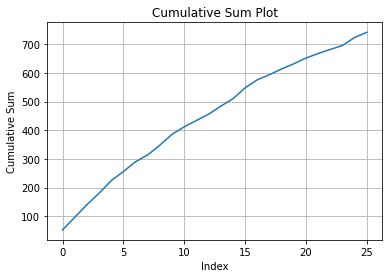

In [122]:
plot_cumulative(regret)

In [123]:
np.sum(regret)

742

In [124]:
# First Stage Regret
# {0: 652, 1: 642}
# Second Stage
# {0: 648, 1: 647}

In [125]:
print('First Half Regret:',(2*(652)))

First Half Regret: 1304


In [126]:
print('Second Half Regret:',np.sum(regret))

Second Half Regret: 742


In [127]:
# First Stage Regret + 2nd Stage Regret
total_regret = (2*(652)) + np.sum(regret)
print('Total Regret:', total_regret)

Total Regret: 2046


In [129]:
correct = 0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    predicted = torch.argmax(net(inputs),axis = 1)
    print(predicted)
    print(labels.to(device))
    
    correct += sum(predicted==labels.to(device)).item()

tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0], device='cuda:0')
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1], device='cuda:0')
tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0], device='cuda:0')
tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0], device='cuda:0')
tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1], device='cuda:0')
tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 0], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,

In [131]:
correct/(i*50)

0.8152

In [128]:
# torch.save(net.state_dict(), 'model_weights.pth')

### Try using the finished model and recalulate regret with the same code?